# Deep Reinforcement Learning Laboratory

This laboratory is focused on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by implementing `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

## Imports and weights and biases login

In [2]:
# Using weights and biases
!pip install wandb -qU


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
import os

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

In [3]:
# Login to weights and biases account
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marco-chisci (marcouni). Use `wandb login --relogin` to force relogin


True

# Exercise 1: `REINFORCE` Implementation (warm up)

## Policy Net
A simple policy network with one hidden layer and a temperature parameter to smooth the output (the higher the temperature the smoother the output)


In [4]:
class PolicyNet(nn.Module):
    def __init__(self, env, hidden_layers=32, temperature=1):
        super().__init__()
        self.temperature = temperature
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, env.action_space.n)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s)/self.temperature, dim=-1)
        return s

## Episode Runner
Class that runs the training episodes collecting all the useful info.

In [5]:
# A class that , given an environment, a policy network and the max lenght of the episode is in charge
# of running it
class Episode_runner:
    def __init__(self, env, policy, maxlen=500):
        self.env = env
        self.policy = policy
        self.maxlen= maxlen

    # Given observation and the policy, sample from pi(a | obs). Returns the
    # selected action and the log probability of that action (needed for policy gradient).
    def select_action(self, obs):
        dist = Categorical(self.policy(obs))
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return (action.item(), log_prob.reshape(1))

    # Given the environment and the policy, run it up to the maximum number of steps.
    def run_episode(self):
        # Collect just about everything.
        observations = []
        actions = []
        log_probs = []
        rewards = []

        # Reset the environment and start the episode.
        (obs, info) = self.env.reset() 
        for i in range(self.maxlen):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            (action, log_prob) = self.select_action(obs)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)

            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = self.env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        return (observations, actions, torch.cat(log_probs), rewards)


## Deterministic Episode Runner
Class that runs the testing episodes. The main difference with the training Episode Runner is that the action selected is always the one with the maximum probability, hence why it's called deterministic.

To test the current best policy, the total average reward and episode length is calculated using the best policy in a deterministic manner on test_episodes episodes.

In [6]:
# A class that , given an episode runner (with an environment and a policy network), an episode render to show the policy 
# and the max lenght of each episode evaluates the quality of the learned policy network, 
# always selecting the action with max probability 
class Determinist_Test_Episode_runner:
    def __init__(self, episode_runner, episode_runner_render, maxlen=500):
        self.ep_runner = episode_runner
        self.ep_run_render = episode_runner_render
        self.maxlen= maxlen

    #select the most probable action given the policy and current observation
    def select_action(self, obs):
        dist = Categorical(self.ep_runner.policy(obs))
        action= torch.argmax(dist.log_prob(dist.enumerate_support()))
        return action.item()

    # Given the environment and the policy, run it up to the maximum number of steps 
    def run_episode(self):
        # Collect just about everything.
        observations = []
        actions = []
        rewards = []

        # Reset the environment and start the episode.
        (obs, info) = self.ep_runner.env.reset() 
        for i in range(self.maxlen):
            # Get the current observation, run the policy and select an action.
            obs = torch.tensor(obs)
            action = self.select_action(obs)
            observations.append(obs)
            actions.append(action)

            # Advance the episode by executing the selected action.
            (obs, reward, term, trunc, info) = self.ep_runner.env.step(action)
            rewards.append(reward)
            if term or trunc:
                break
        return (observations, actions, rewards)

    def test(self, test_episodes):
        print('Testing the best policy')
        self.ep_runner.policy.eval()
        total_reward = 0
        episode_lengths = []
        for _ in range(test_episodes):
            (_, _, rewards) = self.run_episode()
            total_reward += np.sum(rewards)
            episode_lengths.append(len(rewards))
        test_average_episode_len_metric = {"test_average_episode_length": np.mean(episode_lengths)}
        test_average_rewards_metric = {"test_average_total_reward": total_reward / test_episodes}
        wandb.log({**test_average_rewards_metric, **test_average_episode_len_metric})

        (obs, _, _, _) = self.ep_run_render.run_episode()
        self.ep_runner.policy.train()
        print(f'Average Total reward: {total_reward / test_episodes}')

## Reinforce
Implementation of REINFORCE policy gradient algorithm.

It receives two "training" episode runners, one to train the policy and one to show the rendering of some episodes if display = True to see the progress.
The training parameters are:
- gamma: used to compute discounted total reward, balances the importance of immediate versus future reward. A higher value gives a higher weight to future rewards while a lower value prioritizes immediate rewards.
- baseline: the type of baseline used to compute the value function. None (no baseline), std (standard baseline, standardize rewards within the episode) or a ValueNet (the value function is approximated by a Neural Network with the same architecture as the policy network)
- num_episodes: number of training episodes to train the policy and baseline net
- eval_every: after how many training episodes the policy is evaluated
- eval_episodes: the number of episodes the policy is evaluated on
- lr and lr_baseline: learning rates of the policy and baseline net

Given all these inputs, for each episode, the discounted reward, running reward and episode length (in the cartpole case the episode length is equal to the reward of that episode) are computed. If there is a baseline, the policy loss, that is used to optimize the policy, is calculated with the target value. If the baseline is a Neural Network it is also optimized using its loss (how closely it approximates the value function).

After eval_every episodes of training the policy is evaluated on eval_episodes episodes. Instead of using the running average the function calculates the average total reward of the episodes that were runned and their average length. As previously said, these two quantities are the same in Cartpole since the reward of each episode is its length. During this evaluation the best model (the one with the best average reward) is saved.

I also chose to collect all the episodes lengths and losses, every 10 episodes are aggregated in a single value (the mean) to create graphs that are easier to read.

Lastly, the function calculates the average episode length of the entire training to show a general trend, it can be used to investigate the stability of a training and how fast it is able to converge.



In [7]:
# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Implementation of the REINFORCE policy gradient algorithm.
# It receives the episode runner, the wandb run to save the results, the episode runner render that is used to monitor training 
# when display = True, the gamma parameter, the number of episodes to train the policy and baseline net, the type of baseline used,
# eval_every (after how many training steps we evaluate the policy), eval_episode (how many episodes we 
# evaluate the policy on) and the learning rates
def reinforce(episode_runner, wandb, episode_runner_render=None, gamma=0.99, num_episodes=2000,
              baseline=None, display=False, eval_every=100, eval_episodes=100, lr= 1e-2, lr_baseline = 1e-3 ):
    # We use Adam instead of SGD.
    opt = torch.optim.Adam(episode_runner.policy.parameters(), lr= lr)

    # If we have a baseline network, create the optimizer.
    if isinstance(baseline, nn.Module):
        opt_baseline = torch.optim.Adam(baseline.parameters(), lr= lr_baseline)  
        baseline.train()
        print('Training agent with baseline value network.')
    elif baseline == 'std':
        print('Training agent with standardization baseline.')
    else:
        print('Training agent with no baseline.')

    #Collect running rewards, all the episodes lengths and training loss
    running_rewards = [0.0]
    all_episodes_lenghts = []
    training_losses = []
    value_losses = []

    #save the latest policy with the greatest average totale reward
    best_model_state_dict = None
    best_avg_tot_rew = 0
    
    # The main training loop.
    episode_runner.policy.train()
    for episode in range(1, num_episodes+1):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = episode_runner.run_episode()

        # Compute the discounted reward for every step of the episode.
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        running_rewards_metric = {"running_reward": running_rewards[-1]}

        # Handle baseline.
        if isinstance(baseline, nn.Module):
            with torch.no_grad():
                target = returns - baseline(torch.stack(observations))
        elif baseline == 'std':                                       #Standardize returns
            target = (returns - returns.mean()) / returns.std()
        else:
            target = returns

        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * target).mean()
        loss.backward()
        opt.step()

        # Collect each episode length and training loss
        all_episodes_lenghts.append(len(returns))
        training_losses.append(loss.detach().cpu().numpy())
        
        # Log only the mean training loss, episode lenght and running reward of 10 episode to make the graphs cleaner
        if episode % 10 == 0:
            loss_policy_metric = {"loss_policy": np.mean(training_losses[-10:])}
            episode_length_metric = {"episode_length": np.mean(all_episodes_lenghts[-10:])}
            wandb.log({**loss_policy_metric, **episode_length_metric}, commit = False)

        # Update baseline network.
        if isinstance(baseline, nn.Module):
            opt_baseline.zero_grad()
            loss_baseline = ((returns - baseline(torch.stack(observations)))**2.0).mean()
            loss_baseline.backward()
            opt_baseline.step()
            value_losses.append(loss_baseline.detach().cpu().numpy())
            if episode % 10 == 0:
                loss_value_metric = {"loss_value": np.mean(value_losses[-10:])}
                wandb.log({**loss_value_metric}, commit = False)

        # Render and evaluate the current policy after every "eval_every" policy updates.
        if episode % eval_every == 0:
            episode_runner.policy.eval()
            total_reward = 0
            episode_lengths = []
            #evaluate on "eval_episodes" episodes the total reward and the episodes length
            for _ in range(eval_episodes):
                (_, _, _, rewards) = episode_runner.run_episode()
                total_reward += np.sum(rewards)
                episode_lengths.append(len(rewards))
            average_episode_len_metric = {"average_episode_length": np.mean(episode_lengths)}
            average_rewards_metric = {"average_total_reward": total_reward / eval_episodes}
            wandb.log({**average_rewards_metric, **average_episode_len_metric}, commit = False)
            # Update best policy, the one with the best average total reward at testing time
            if  total_reward / eval_episodes >= best_avg_tot_rew:
                best_avg_tot_rew = total_reward / eval_episodes
                # save all the parameters of the best policy
                best_model_state_dict = episode_runner.policy.state_dict()
            if display:
                (obs, _, _, _) = episode_runner_render.run_episode()
            episode_runner.policy.train()
            print(f'Running reward of episode {episode}/{num_episodes}: {running_rewards[-1]}')
            print(f'Average Total reward: {total_reward / eval_episodes}')
        
        wandb.log({**running_rewards_metric})

    # Lastly, calculate and print the average episode lenght of the entire training
    print(f'Average length of all episodes: {np.mean(all_episodes_lenghts)}')
    average_all_episodes_metric= {"average_lenght_all_episodes": np.mean(all_episodes_lenghts)}
    wandb.log({**average_all_episodes_metric})
    
    episode_runner.policy.eval()
    if isinstance(baseline, nn.Module):
        baseline.eval()
    return best_model_state_dict
    

# Standard runs
In the following section I tested `REINFORCE` on the Cartpole environment using the standard baseline while changing the parameters (temperature and gamma).

Since training the policy is stochastic, for each setting I performed the policy training 5 times with 5 different seeds to be able to replicate the experiments.

At the end of this section there will be a wandb report with the results, for every setting the 5 runs are aggregated showing their mean and variance.

## Standard run
Base parameters, temperature = 1 and gamma = 0.99

In [ ]:
# Random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Standard Run ",
          config={
              "hidden_layers": 32,
              "num_episodes": 2000,
              "gamma": 0.99,
              "baseline": 'std',
              "eval_every":100,
              "eval_episodes": 20,
              "test_episodes" : 200,
              "temperature" : 1,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    # Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    # Set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= config.baseline, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## Standard run and higher temperature (5)
Higher temperature, temperature = 5 and gamma = 0.99

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Standard and temperature 5 ",
          config={
              "hidden_layers": 32,
              "num_episodes": 2000,
              "gamma": 0.99,
              "baseline": 'std',
              "eval_every":100,
              "eval_episodes": 20,
              "test_episodes" : 200,
              "temperature" : 5,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= config.baseline, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## Standard run and higher temperature (10)
Even higher temperature, temperature = 10 and gamma = 0.99

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Standard and temperature 10 ",
          config={
              "hidden_layers": 32,
              "num_episodes": 2000,
              "gamma": 0.99,
              "baseline": 'std',
              "eval_every":100,
              "eval_episodes": 20,
              "test_episodes" : 200,
              "temperature" : 10,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= config.baseline, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## Standard run and lower gamma
Higher temperature (since it achieved better results) and lower gamma, temperature = 5 and gamma = 0.9

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Standard and gamma 0.9 ",
          config={
              "hidden_layers": 32,
              "num_episodes": 2000,
              "gamma": 0.9,
              "baseline": 'std',
              "eval_every":100,
              "eval_episodes": 20,
              "test_episodes" : 200,
              "temperature" : 5,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= config.baseline, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## Standard Runs Report
This is the public report created with weights and biases: https://api.wandb.ai/links/marcouni/c8d6xyuv

It is quite easy to see that the best performance is obtained when the temperature is 5 and gamma is 0.99. Its average total reward is almost always the highest and it is extremely fast to converge (highest average length of all episodes) to a very stable perfect policy (always able to reach the 500th step in each episode). Its test average reward is perfect, meaning that the final policy is one of the possible best policies for this environment.

The standard run and the one with temperature = 10 are not that different, except that the latter seems to be a little slower to converge (lower average length of all episodes) but is more stable (perfect test average total reward).

It is also clear that the worst run is the one with a lower gamma, being the worst by every metric. This result shows the importance of future steps (through the importance of future rewards) in Cartpole. 

# Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**.

# Different baselines
This section contains the results of the experiments with REINFORCE on Cartpole using different kinds of baselines (no baseline, standard baseline and a Value Net as a baseline).

Since previously the best results were obtained with temperature = 5 and gamma = 0.99 these parameters will be used in all the following runs. I also experimented with changing the number of layers of the Policy and Value Nets.

Once again, for each setting I performed the policy training 5 times with 5 different seeds to be able to replicate the experiments and at the end of this section there will be a wandb report with the results.

## Without the baseline
Since I already experimented with Reinforce with the standard baseline the next run will not cointain a baseline of any kind

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Without the baseline ",
          config={
              "hidden_layers": 32,
              "num_episodes": 2000,
              "gamma": 0.99,
              "baseline": None,
              "eval_every":100,
              "eval_episodes": 20,
              "test_episodes" : 200,
              "temperature" : 5,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= config.baseline, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## With Baseline network
Using ValueNet, a simple Net with the same architecture as the Policy Net that has to learn to estimate the value function

In [8]:
class ValueNet(nn.Module):
    def __init__(self, env, hidden_layers=32):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, 1)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return s

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Baseline Network ",
          config={
              "hidden_layers": 32,
              "num_episodes": 2000,
              "gamma": 0.99,
              "baseline": 'net',
              "eval_every":100,
              "eval_episodes": 20,
              "test_episodes" : 200,
              "temperature" : 5,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)

    # Make a value network
    value = ValueNet(env, config.hidden_layers)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= value, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## With baseline, 128 hidden layer
Adding more hidden layers to the ValueNet and PolicyNet

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Baseline Network 128 layers temp 5",
          config={
              "hidden_layers": 128,
              "num_episodes": 2000,
              "gamma": 0.99,
              "baseline": 'net',
              "eval_every":100,
              "eval_episodes": 20,
              "test_episodes" : 200,
              "temperature" : 5,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)

    # Make a value network
    value = ValueNet(env, config.hidden_layers)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= value, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## With baseline, 16 hidden layer
Lowering the number of hidden layers of the ValueNet and PolicyNet

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Baseline Network 16 layers temp 5",
          config={
              "hidden_layers": 16,
              "num_episodes": 2000,
              "gamma": 0.99,
              "baseline": 'net',
              "eval_every":100,
              "eval_episodes": 20,
              "test_episodes" : 200,
              "temperature" : 5,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)

    # Make a value network
    value = ValueNet(env, config.hidden_layers)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= value, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## Baselines Runs Report
This is the public report created with weights and biases: https://api.wandb.ai/links/marcouni/0ksdyjpo

Once again the best setting seems to be the one with a standard baseline and temperature = 5, closely followed by the settings with baseline networks with 32 (standard) and 128 hidden layers (more layers achieve a slightly better result). Given these results using a standard baseline and temperature = 5 seems like the best case scenario for Cartpole.
This is probably due to the simplicity (the standardized mean of the discounted return seems like a very good approximation of the value function) of the problem since its convergence is incredibly fast and stable. 

Using a ValueNet also leads to a stable training and a perfect policy (the test average total reward is perfect with 32 and 128 hidden layers) but seems to slow down the convergence as it needs more time to learn to approximate the value function. 

When the layers of the two Networks are not enough (16 hidden layers) they are unable to correctly approximate the value function and the policy.

As expected the setting with no baseline produces the worst results, the runs are much less stable, as it can be seen in average total reward and average length all episodes. The final policy is also extremely unstable, it can be perfect or horrible ( test average total reward has a very high variance).

 # Longer runs
 Lastly I also experiments with much longer runs with two of the best settings, with standard baseline and ValueNet, to see if their performance gap was due to the number of training episodes.

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Long Standard",
          config={
              "hidden_layers": 32,
              "num_episodes": 5000,
              "gamma": 0.99,
              "baseline": 'std',
              "eval_every":100,
              "eval_episodes": 50,
              "test_episodes" : 500,
              "temperature" : 5,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= config.baseline, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

In [ ]:
#random seeds, to reproduce the same results
seeds = [1, 11, 111, 1111, 11111]
for i in range(len(seeds)):

    # Training and arhitecture hyperparameters, initialise a wandb run
    run=wandb.init(
          project="Lab3-DRL-warmups",
          name = "Long Baseline Network ",
          config={
              "hidden_layers": 32,
              "num_episodes": 5000,
              "gamma": 0.99,
              "baseline": 'net',
              "eval_every":100,
              "eval_episodes": 50,
              "test_episodes" : 500,
              "temperature" : 5,
              "lr" : 1e-2,
              "lr_baseline" : 1e-3
              })
    
    # Copy the configuration
    config = wandb.config

    #Instaintiate two versions of cartpole, one that animates the episodes (which slows everything
    # down), and another that does not animate.
    env = gymnasium.make('CartPole-v1')
    env_render = gymnasium.make('CartPole-v1', render_mode='human')

    #set the seed
    torch.manual_seed(seeds[i])
    env.reset(seed = seeds[i])
    env_render.reset(seed = seeds[i])
    
    # Make a policy network.
    policy = PolicyNet(env, config.hidden_layers, config.temperature)

    # Make a value network
    value = ValueNet(env, config.hidden_layers)
    
    # Create episode_runner
    episode_runner= Episode_runner(env, policy)
    episode_runner_rend= Episode_runner(env_render, policy)
    
    # Train the agent
    best_model_state_dict = reinforce(episode_runner, run, episode_runner_rend, gamma=config.gamma, num_episodes=config.num_episodes,
              baseline= value, display=False, eval_every=config.eval_every,
              eval_episodes=config.eval_episodes, lr= config.lr, lr_baseline = config.lr_baseline )
    
    # Load the best policy on the determinist episode runner to test it
    episode_runner.policy.load_state_dict(best_model_state_dict)
    det_ep_runner = Determinist_Test_Episode_runner(episode_runner, episode_runner_rend )
    det_ep_runner.test(test_episodes=config.test_episodes)
    
    # Close up everything
    env_render.close()
    env.close()

## Longer Runs Report
This is the public report created with weights and biases: https://api.wandb.ai/links/marcouni/r8dqdyc5

It is clear that increasing the number of training episodes deteriorates both settings' performances, making the training more unstable and the final policy less good. The one that suffers a worse decline in reward is the one with ValueNet, probably due to overfitting. 


# Video recording

In [ ]:
from gymnasium.wrappers import RecordVideo

env_render = gymnasium.make('CartPole-v1', render_mode="rgb_array")

# wrap the env in the record video
recorder = gymnasium.wrappers.RecordVideo(env=env_render, video_folder="/data01/dl24marchi/DLAProjects/videos", name_prefix="test-video", episode_trigger=lambda x: x%10 == 0)

# env reset for a fresh start
observation, info = recorder.reset()

###
# Start the recorder
recorder.start_video_recorder()

# And run the final agent for a few episodes.
for _ in range(100):
    run_episode(recorder, policy)

####
# Don't forget to close the video recorder before the env!
recorder.close_video_recorder()

env_render.close()

-----
# Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest)

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.



## CarRacing-v2 environment

The raw frames are preprocessed by cropping an 84 × 84 region of the image that roughly captures the playing area (every frame always contains a black area at the bottom of the frame, so we cut that black area) and converting their RGB representation to gray-scale.

In [15]:
import cv2

def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

The game screen gradually zooms in for the first 50 steps, thus, we will not use the first 50 steps of the game.

The preprocessing is applied to the last 4 frames, they are stacked to produce the input to the Q-function.

A simple frame-skipping technique is used: the agent sees and selects actions on every kth frame instead of every frame and its last action is repeated on skipped frames. Running the emulator forward for one step requires much less computation than having the agent select an action, this technique allows the agent to play roughly k times more games without significantly increasing the runtime.

ImageEnv is a gymnasium wrapper that redefines reset() and step() following the previously defined changes.

In [19]:
class ImageEnv(gymnasium.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,         # How many frames are skipped
        stack_frames=4,        # How many frames to stack
        initial_no_op=50,      # No actions during the zoom in
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
    
    def reset(self):
        # Reset the original environment.
        state, info = self.env.reset()

        # Do nothing for the first `self.initial_no_op` steps, zoom in
        for _ in range(self.initial_no_op):
            state, _, _, _, info = self.env.step(0)   # action 0 : do nothing
        
        # Convert a frame to 84 X 84 gray scale one
        state = preprocess(state)

        # The initial observation is simply a copy of the frame `s`, np.tile repeats s self.stack_frames times
        self.stacked_state = np.tile(state, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info
    
    def step(self, action):
        # We take the same action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            state, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        state = preprocess(state)

        # Push the current frame `state` at the end of self.stacked_state while removing the oldest frame
        self.stacked_state = np.concatenate((self.stacked_state[1:], state[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

The shape of an observation:  (4, 84, 84)


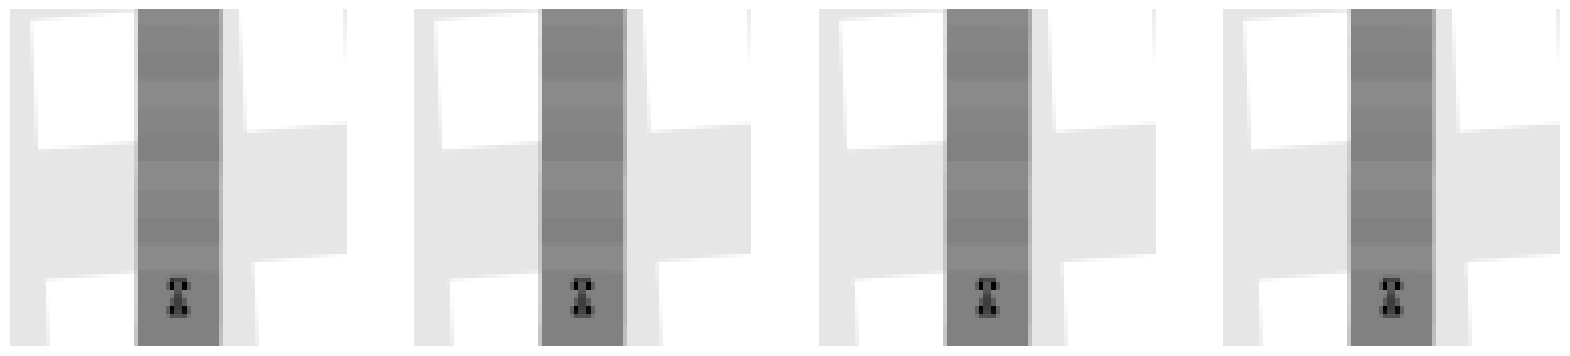

In [22]:
# Discrete action space: do nothing, steer left, steer right, gas, brake.
env = gymnasium.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

# Check reset
state, _ = env.reset()
print("The shape of an observation: ", state.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(state[i], cmap='gray')
    axes[i].axis('off')
plt.show()

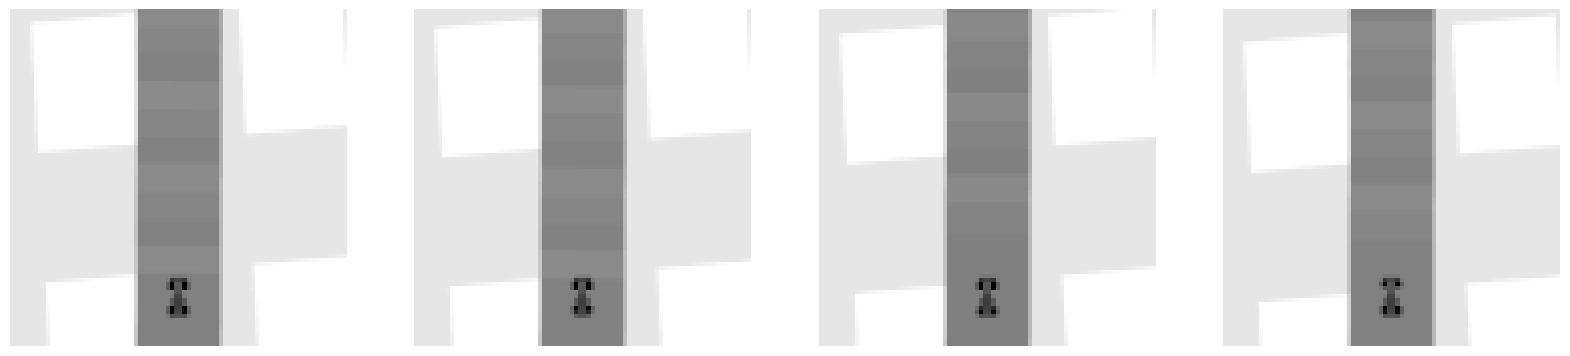

In [23]:
# Check step, gas action for 4 steps, check moving background
for i in range(4):
    state, r, terminated, truncated, info = env.step(3)  # 3rd action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(state[i], cmap='gray')
    axes[i].axis('off')
plt.show()

## DQN
A Neural Network that takes in n_observations frames and tries to predict the expected return of taking each possible action given the current input.

In [7]:
import torch
import torch.nn as nn

class NetDQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(NetDQN, self).__init__()
        self.conv1 = nn.Conv2d(n_observations, 16, kernel_size=7, stride=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        # Image 5*5 after convolutions and max pooling
        self.fc1 = nn.Linear(32*5*5, 256)  
        self.fc2 = nn.Linear(256, n_actions)   
        self.max_pool= nn.MaxPool2d(kernel_size= (2,2))
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool(x)
        x = torch.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Replay Buffer
It stores the transitions (state, action, next state, reward) that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated.

In [14]:
class ReplayBuffer():
	def __init__(self, state_dim, action_dim, max_size=int(1e5)):
		self.max_size = max_size
		self.ptr = 0     # Pointer
		self.size = 0    # Current size

		self.state = np.zeros((max_size, *state_dim), dtype=np.float32)
		self.action = np.zeros((max_size, *action_dim), dtype=np.int64)
		self.next_state = np.zeros((max_size, *state_dim), dtype=np.float32)
		self.reward = np.zeros((max_size, 1), dtype=np.float32)
		self.terminated = np.zeros((max_size, 1), dtype=np.float32)

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, terminated):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = terminated

        # Update pointer and current size
		self.ptr = (self.ptr + 1) % self.max_size  
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		# Collect batch_size random integers from 0 to current size 
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.terminated[ind]).to(self.device)
		)

## DQNAgent
DQN agent:

- act() takes as input one state and outputs an action by following an epsilon-greedy policy.

- learn() samples a batch from replay buffer and trains the NetDQN with MSE loss using temporal difference

- process() takes one transition (state, action, next state, reward) as input and decides if the agent can learn (after the warmup) and if the target network has to be updated, it also decays the current epsilon.


In [15]:
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=0.0005,
        epsilon=1.0,
        epsilon_min=0.1,
        gamma=0.99,
        batch_size=64,
        warmup_steps=2500,
        buffer_size=int(1e5),
        target_update_interval=5000,
    ):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval   # After how many steps update target net

        self.network = NetDQN(state_dim[0], action_dim)
        self.target_network = NetDQN(state_dim[0], action_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        self.network.to(self.device)
        self.target_network.to(self.device)
        
        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 5e5
    
    @torch.no_grad()
    def act(self, state, training=True):
        # Set network to train() mode if training
        self.network.train(training)
        # Random action if training and if randomly chosen with epsilon or we are in the first warmup steps
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            action = np.random.randint(0, self.action_dim)
        # Follow the current policy, select best action given the approximated q value
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            qvalue = self.network(state)
            action = torch.argmax(qvalue).item()
        return action
    
    def learn(self):
        # Sample batch size transitions from replay buffer 
        state, action, next_state, reward, terminated = self.buffer.sample(self.batch_size)
        
        # Calculated with the target network, detach: do not train the target net
        next_qvalue = self.target_network(next_state).detach()
        temporal_difference_target = reward + (1. - terminated) * self.gamma * next_qvalue.max(dim=1, keepdim=True).values
        # MSE loss between current q value (gather q value that corresponds to action) and temporal difference of the target
        loss = F.mse_loss(self.network(state).gather(1, action.long()), temporal_difference_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        result = {
            'reward': reward,
            'training_loss': loss.item()
        }
        
        return result
    
    def process(self, transition):
        result = {}
        self.total_steps += 1
        self.buffer.update(*transition)
        
        # Start learning after the warmup
        if self.total_steps > self.warmup_steps:
            result = self.learn()
        
        # Update the target network
        if self.total_steps % self.target_update_interval == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        # Epsilon decay
        self.epsilon -= self.epsilon_decay
        return result

## Training the DQN Agent

In [ ]:
# Function to evaluate the agent 
def evaluate(eval_env, agent, n_evals=10):
    scores = 0
    episode_length = 0
    for _ in range(n_evals):
        (state, _), done, ret = eval_env.reset(), False, 0
        while not done:
            action = agent.act(state, training=False)
            next_state, reward, terminated, truncated, info = eval_env.step(action)
            state = next_state
            ret += reward
            episode_length += 1
            done = terminated or truncated
        scores += ret
    result = {
            'scores': np.round(scores / n_evals, 4),
            'average_length': np.round(episode_length / n_evals, 4)
        }
    return result

Train the DQN Agent for 1 million steps and evaluate it every 5000 steps.

In [16]:
run=wandb.init(
          project="Lab3-DRL-DQN_Agent",
          name = "Training DQN",
          config={
            "lr" : 0.0005,
            "epsilon" : 1.0,
            "epsilon_min" : 0.1,
            "gamma" : 0.99,
            "batch_size" : 64,
            "warmup_steps" : 2500,
            "buffer_size" :int(1e5),
            "target_update_interval" : 5000
            "max_steps": int(1e6)
            "eval_interval" : 5000
              })
    
# Copy the configuration
config = wandb.config

# Create environments to train and evaluate
env = gymnasium.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

eval_env = gymnasium.make('CarRacing-v2', continuous=False)
eval_env = ImageEnv(eval_env)

# General definitions
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim, config.lr, config.epsilon, config.epsilon_min, config.gamma, config.batch_size,
                 config.warmup_steps, config.buffer_size, config.target_update_interval)

RuntimeError: No CUDA GPUs are available

In [ ]:
state, _ = env.reset()
# To save the best agent, the one with the best eval avg score
best_avg_score = 0
while True:
    action = agent.act(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    result = agent.process((state, action, reward, next_state, terminated))  

    state = next_state
    if terminated or truncated:
        state, _ = env.reset()
        
    if agent.total_steps % config.eval_interval == 0:
        ret = evaluate(eval_env, agent)

        scores_metric = {"Average Eval Scores": ret['scores']}
        episode_length_metric = {"Average Episode Length": ret['average_length']}
        wandb.log({**scores_metric, **episode_length_metric}, commit = False)
        
        # Save the best agent
        if best_avg_score < ret['scores']:
            best_avg_score = ret['scores']
            # Save all the parameters of the model
            model_state_dict = agent.network.state_dict()
    
    loss_metric = {"Trainin Loss": result['training_loss']}
    training_reward_metric = {"Training Reward": result['reward']}
    wandb.log({**loss_metric, **training_reward_metric})
    
    if agent.total_steps > config.max_steps:
         # Load saved weights of the best model
        agent.network.load_state_dict(model_state_dict)

        # Save the best model on weights and biases as an artifact
        model_artifact = wandb.Artifact(
                    "DQN_Agent" , type="model",
                    description="best model for Lab3-DRL",
                    metadata=dict(config))

        torch.save(agent.network.state_dict(), "best_model.pth")
        model_artifact.add_file("best_model.pth")
        wandb.save("best_model.pth")
        run.log_artifact(model_artifact)
        break

## Final evaluation

In [ ]:
test_env = gymnasium.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
test_env = ImageEnv(test_env)

frames = []
scores = 0
(state, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(test_env.render())
    action = agent.act(state, training=False)
    next_state, reward, terminated, truncated, info = test_env.step(action)
    state = next_state
    ret += reward
    done = terminated or truncated
scores += ret

In [ ]:
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random
    
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

In [ ]:
animate(frames)